In [1]:
import pandas as pd

orig_data = pd.read_csv("../data/orig_cancer_data.csv")

In [2]:
from sdv.metadata import SingleTableMetadata

# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(orig_data)
# metadata.save_to_json("cancer_metadata.json")

metadata = SingleTableMetadata.load_from_json("../cancer_metadata.json")

In [65]:
from sdv.single_table import CTGANSynthesizer

# synthesizer = CTGANSynthesizer(
#     metadata,
#     embedding_dim=1280,
#     generator_dim=(1280, 1280),
#     discriminator_dim=(1280, 1280),
#     generator_lr=1.6e-4,
#     generator_decay=0.4e-6,
#     discriminator_lr=2e-4,
#     discriminator_decay=0.5e-6,
#     epochs=4500,
#     verbose=True,
# )

synthesizer = CTGANSynthesizer.load("../models/synthesizer.pkl")

In [62]:
synthesizer.fit(orig_data)

Gen. (-3.20) | Discrim. (-1.27): 100%|██████████| 4500/4500 [07:18<00:00, 10.27it/s]


<Axes: xlabel='Epoch', ylabel='Loss'>

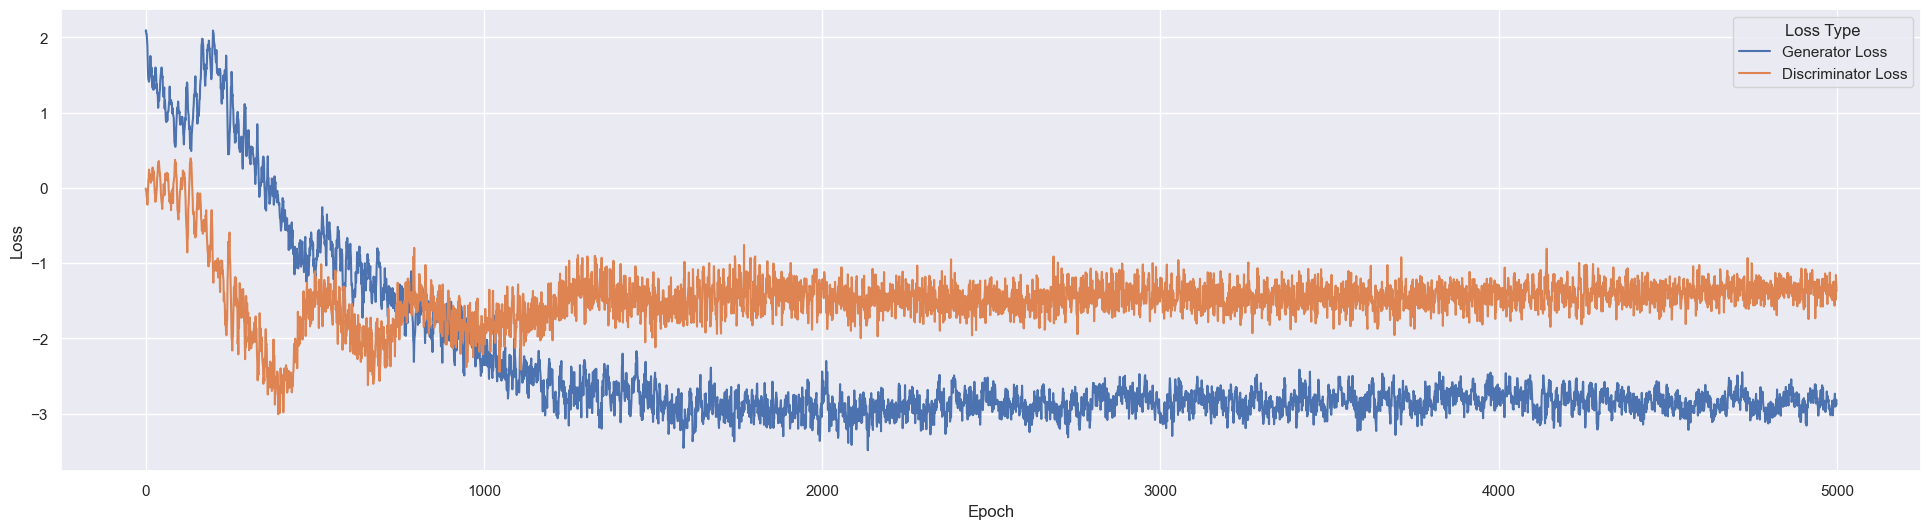

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

plt.figure(figsize=(24, 6))
sns.lineplot(
    synthesizer.get_loss_values().melt(id_vars="Epoch", var_name="Loss Type", value_name="Loss"),
    x="Epoch", y="Loss",
    hue="Loss Type",
)

In [28]:
synthesizer.save('synthesizer.pkl')

In [3]:
from sdv.evaluation.single_table import evaluate_quality

# sample = synthesizer.sample(111000, batch_size=500)
# synth_data = pd.concat([orig_data, sample], ignore_index=True).drop_duplicates()
synth_data = pd.read_csv("../data/new_cancer_data.csv")
report = evaluate_quality(orig_data, synth_data, metadata)
synth_data.info()

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 276/276 [00:34<00:00,  7.98it/s]

Overall Score: 87.16%

Properties:
- Column Shapes: 93.46%
- Column Pair Trends: 80.86%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100755 entries, 0 to 100754
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Age                       100755 non-null  int64 
 1   Gender                    100755 non-null  object
 2   Air Pollution             100755 non-null  int64 
 3   Alcohol Usage             100755 non-null  int64 
 4   Dust Allergy              100755 non-null  int64 
 5   Occupational Hazards      100755 non-null  int64 
 6   Genetic Risk              100755 non-null  int64 
 7   Chronic Lung Disease      100755 non-null  int64 
 8   Balanced Diet             100755 non-null  int64 
 9   Obesity                   100755 non-null  int64 
 10  Smoking                 

In [71]:
synth_data.to_csv("../data/new_cancer_data.csv", index=False)